In [1]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch

d:\Pyhton\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["HF_HOME"] = "D:/hf_cache"
os.environ["TRANSFORMERS_CACHE"] = "D:/hf_cache/transformers"
os.environ["HF_DATASETS_CACHE"] = "D:/hf_cache/datasets"
os.environ["TMPDIR"] = "D:/tmp"

In [3]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

In [4]:
label_names = ["neutral", "bullish", "bearish"]
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

In [5]:
def tokenize_fn(tokenizer):
    def preprocess(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)
    return preprocess

In [6]:
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=-1)
    return {"accuracy": (preds == pred.label_ids).mean()}

In [7]:
def get_training_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        num_train_epochs=4,
        weight_decay=0.01,
        load_best_model_at_end=False,
        metric_for_best_model="accuracy",
        logging_dir=f"{output_dir}/logs",
    )

In [8]:
def train_and_evaluate(model_name, output_dir):
    print(f"\n🚀 Fine-tuning model: {model_name}\n")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

    # Preprocessing
    encoded = dataset.map(tokenize_fn(tokenizer), batched=True)
    encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    train_ds = encoded["train"]
    val_ds = encoded["validation"]

    # Trainer
    trainer = Trainer(
        model=model,
        args=get_training_args(output_dir),
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    pred = trainer.predict(val_ds)
    y_pred = np.argmax(pred.predictions, axis=1)
    y_true = pred.label_ids

    # Metrics
    print(f"📊 Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=label_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.show()

    return pred.metrics["test_accuracy"]


🚀 Fine-tuning model: mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis



C:\Users\farre\AppData\Local\Temp\ipykernel_26480\2501595379.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.572300,0.360021,0.860972
2,0.338700,0.326755,0.886516
3,0.251700,0.404266,0.880653
4,0.196900,0.464989,0.884841


📊 Classification Report for mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis:

              precision    recall  f1-score   support

     neutral       0.77      0.84      0.80       347
     bullish       0.80      0.87      0.83       475
     bearish       0.94      0.90      0.92      1566

    accuracy                           0.88      2388
   macro avg       0.84      0.87      0.85      2388
weighted avg       0.89      0.88      0.89      2388



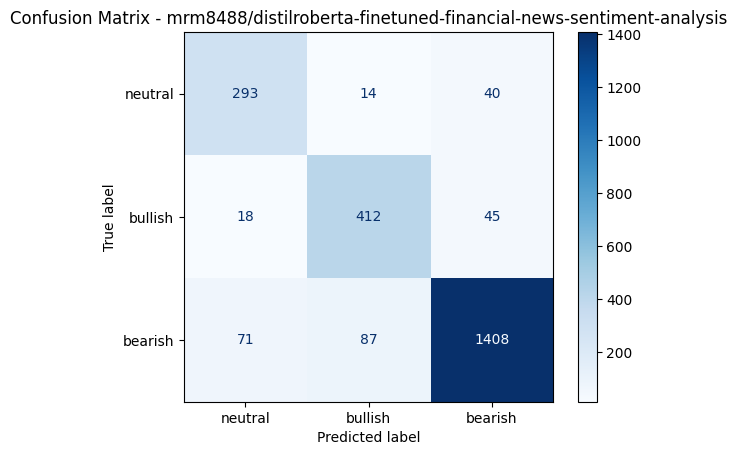

In [9]:
acc1 = train_and_evaluate("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", "results-distilroberta")


🚀 Fine-tuning model: ahmedrachid/FinancialBERT-Sentiment-Analysis



Error while downloading from https://cdn-lfs.hf.co/ahmedrachid/FinancialBERT-Sentiment-Analysis/aa62f8baa25b9530ccf34944da817cc1eb73c20e3b021e33db754302b49ae4bf?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1753455661&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MzQ1NTY2MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9haG1lZHJhY2hpZC9GaW5hbmNpYWxCRVJULVNlbnRpbWVudC1BbmFseXNpcy9hYTYyZjhiYWEyNWI5NTMwY2NmMzQ5NDRkYTgxN2NjMWViNzNjMjBlM2IwMjFlMzNkYjc1NDMwMmI0OWFlNGJmP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=KXZzMRL1EMh2ck2NJt4W8BlEENUxXr4ydR1xKWnQrBtYi0%7EaF1LKJcw3kV1o-5MUM88Wde8-iq3KBSDb-5PTFm1n4Ln4wC1XjcCE8eM3ctMv0-8Lf2Kp3aKgKPYI0J%7EcI-vCloTtZsuhuxcCnLWdFKc36Pp3-C-WluFmvMmz-znrw9k5cYr8ZVxGGQsMn7qN6mxe4tMgiI5LeY8saTGiScwLSOhC3SP5MhVc5hmBdkuH%7EilWlgag%7EEFNjYajGD71

Epoch,Training Loss,Validation Loss,Accuracy
1,0.622500,0.472136,0.816164
2,0.400300,0.431910,0.847152
3,0.264200,0.519973,0.840871
4,0.202600,0.657846,0.839196


Error while downloading from https://cdn-lfs.hf.co/ahmedrachid/FinancialBERT-Sentiment-Analysis/0397591988f90d546a8ed3e4d527389524c1422625947eb81e003106e8d33b20?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1753456332&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MzQ1NjMzMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9haG1lZHJhY2hpZC9GaW5hbmNpYWxCRVJULVNlbnRpbWVudC1BbmFseXNpcy8wMzk3NTkxOTg4ZjkwZDU0NmE4ZWQzZTRkNTI3Mzg5NTI0YzE0MjI2MjU5NDdlYjgxZTAwMzEwNmU4ZDMzYjIwP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=rDKntvTl6gI8p-CmZLfCRxI2yu14eTVE28Gxx2vvzMXVQ8l2WaLGkrQnAymZi5lcPbPVxlQJCUxlOey6k2lnSdrNVrcBaJ35VTwF64WoGCvDzQdWwJTx8dxdQGFDj4vzym1eQvWR781lc5i4LyFb5Lt%7EvHHqhPHN7rNRpw-YoHj0NeTtbDkpo8BH0fJFRuancVOyId%7E7g-zdNFRY79fYmRYH0JL-Z0whVDQy1kZ0Ms6pZ0dIfNvGa5%7EZCVJWt6CtRu4jXTosueg7qYj7t%7EGTH8TisHOJgpp2aDIAnMVN0Ml2%7E53-kLJbKCyF113KVfdn2r18xq5%7ESAK8z

📊 Classification Report for ahmedrachid/FinancialBERT-Sentiment-Analysis:

              precision    recall  f1-score   support

     neutral       0.69      0.73      0.71       347
     bullish       0.76      0.73      0.74       475
     bearish       0.90      0.90      0.90      1566

    accuracy                           0.84      2388
   macro avg       0.78      0.78      0.78      2388
weighted avg       0.84      0.84      0.84      2388



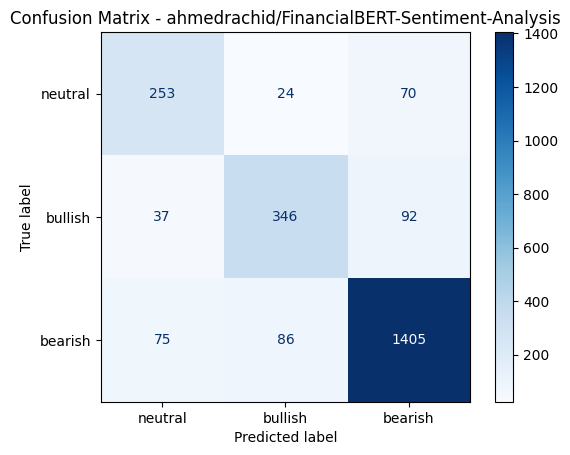

In [13]:
acc2 = train_and_evaluate("ahmedrachid/FinancialBERT-Sentiment-Analysis", "results-finbert-tone")

In [14]:
print("\n📈 Accuracy Comparison:")
print(f"DistilRoBERTa (mrm8488):  {acc1 * 100:.2f}%")
print(f"FinBERT (yya518):         {acc2 * 100:.2f}%")


📈 Accuracy Comparison:
DistilRoBERTa (mrm8488):  88.48%
FinBERT (yya518):         83.92%
